In [1]:
%ls

clean_data.py*                       landsend_veg_2007_2012.csv*
cleaned_landsend_veg_2007_2012.csv*  lrs_goldengate_EDA.ipynb*
define_column.py*                    preprocess.ipynb*
ideal_mix.json*                      README.md*


## first import packages needed

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
df = pd.read_csv("landsend_veg_2007_2012.csv")
df.head()

,Site-YearCode,Transect,Point,Height,Species,Plant code,Native Status,Life History,Stature
0,NUWO-2012,5,90,Low,-,-,-,-,-
1,NUWO-2012,13,150,Low,-,-,-,-,-
2,NMS-2010,8,20,Low,Achillea millefolium,ACMI,Native,Perennial,Forb
3,NMS-2010,24,4,Low,Achillea millefolium,ACMI,Native,Perennial,Forb
4,NMS-2010,48,16,Low,Achillea millefolium,ACMI,Native,Perennial,Forb


this is a wrong data point (**"SUDO-2014"**) according to Naomi, please delete it!

In [4]:
valid = df["Site-YearCode"] == "SUDO-2014"
df.loc[valid]

,Site-YearCode,Transect,Point,Height,Species,Plant code,Native Status,Life History,Stature


 count the frequencies of species in the data set

In [61]:
species = df[["Species"]].copy()
species["counts"] = 1
species_freq = species.groupby("Species").agg(sum).iloc[:,0].copy()
species_freq.sort(ascending=False)

/usr/local/lib/python3.4/dist-packages/IPython/kernel/__main__.py:4: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting


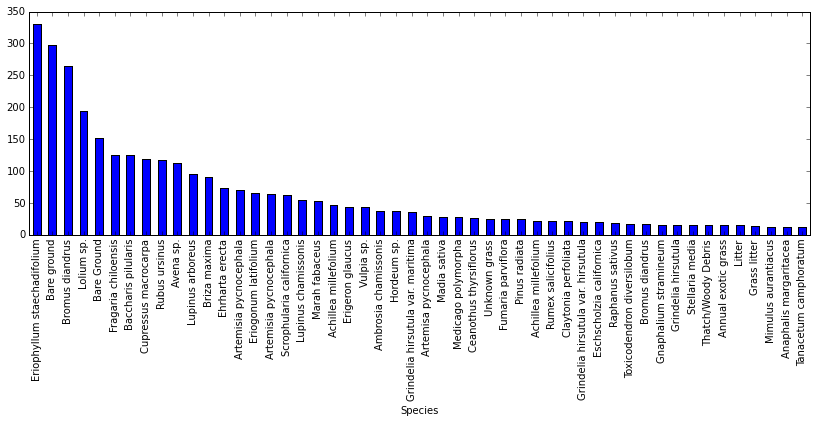

In [62]:
plt.figure(figsize=(14,4))
species_freq[:50].plot(kind = "bar")
pass

Extract the **columns** we need (`"Site-YearCode"`, `"Species"`), and take **rows** which have no missing values ("-")

In [63]:
df_yr_sp = df[["Site-YearCode", "Species"]]
valid = ~ df_yr_sp.applymap( lambda x: x == "-").any(axis=1)
df_yr_sp = df_yr_sp.loc[valid]

split the `Site-YearCode` column into `site` and `year` columns

In [64]:
get_year = lambda x : int(x.split("-")[-1])
df_yr_sp["year"] = df_yr_sp["Site-YearCode"].map( get_year )

get_site = lambda x : (x.split("-")[0])
df_yr_sp["site"] = df_yr_sp["Site-YearCode"].map( get_site )

df_yr_sp.drop("Site-YearCode", axis=1, inplace = True)
df_yr_sp.head()

,Species,year,site
2,Achillea millefolium,2010,NMS
3,Achillea millefolium,2010,NMS
4,Achillea millefolium,2010,NMS
5,Achillea millefolium,2010,NMS
6,Achillea millefolium,2011,NMS


###Grouping

toy example: iterate over site and year groups:

In [9]:
for kk, vv in df_yr_sp.groupby(["site", "year"]):
    print(kk, vv["Species"].unique().shape[0] )

('EAPO', 2011) 31
('NMS', 2010) 45
('NMS', 2011) 35
('NMS', 2012) 54
('NUWO', 2010) 54
('NUWO', 2011) 25
('NUWO', 2012) 47
('SUDU', 2008) 33
('SUDU', 2009) 40
('SUDU', 2010) 35
('SUDU', 2011) 31
('SUDU', 2012) 41
('SUDU', 2013) 4


In [104]:
spnum = df_yr_sp.groupby(["site", "year"]).agg("count")["Species"]
spnum.head()

site  year
EAPO  2011    390
NMS   2010    247
      2011    175
      2012    335
NUWO  2010    320
Name: Species, dtype: int64

In [105]:
spnum_t = pd.pivot_table( spnum.reset_index() , index = "year", columns= "site")["Species"]#.fillna(0)
spnum_t

site,EAPO,NMS,NUWO,SUDU
year,,,,
2008,NaN,NaN,NaN,498
2009,NaN,NaN,NaN,505
2010,NaN,247,320,222
2011,390,175,115,177
2012,NaN,335,400,200
2013,NaN,NaN,NaN,5


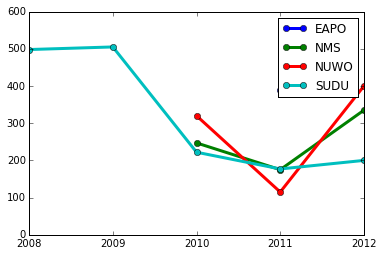

In [108]:
xlims = (2008, 2012)

plt.plot(spnum_t.index.tolist(), spnum_t, "o-", lw = 3)

x_formatter = plt.matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.gca().xaxis.set_major_formatter(x_formatter)
plt.xlim(xlims)
plt.xticks(range(xlims[0], xlims[-1]+1))
plt.legend(spnum_t.columns.tolist())
pass

more grouping excersise

In [12]:
df_yr_sp["count"] = 1

df_site_sp_yr = df_yr_sp.\
groupby(["site", "year",  "Species",]).agg("count").\
reset_index().set_index("site")

df_site_sp_yr.loc["SUDU"].head()

,year,Species,count
site,,,
SUDU,2008,Abronia latifolia,5
SUDU,2008,Achillea millefolium,12
SUDU,2008,Ambrosia chamissonis,14
SUDU,2008,Artemisia californica,1
SUDU,2008,Artemisia pycnocephala,67


_note that `"count"` in `.agg("count")` here is not a column name, but a name of a function!_

In [13]:
df_num_species = df_site_sp_yr.reset_index().copy()
df_num_species.drop("count", axis = 1).\
    groupby(["site","year"]).agg("count")

Species
site year         
EAPO 2011       31
NMS  2010       45
     2011       35
     2012       54
NUWO 2010       54
     2011       25
     2012       47
SUDU 2008       33
     2009       40
     2010       35
     2011       31
     2012       41
     2013        4

### Pivoting

In [14]:
cols = ["Species","year", "site"]
df_yr_sp["count"] = 1

In [29]:
dfpiv_sudu = pd.pivot_table(
    df_site_sp_yr.loc["SUDU"],
    index = "Species", columns = "year").fillna(0)["count"]

dfpiv_sudu.head()

year,2008,2009,2010,2011,2012,2013
Species,,,,,,
Abronia latifolia,5,1,1,0,1,0
Achillea millefolium,0,0,5,4,5,0
Achillea millefolium,12,10,0,0,0,0
Albizia lophantha,0,1,1,0,1,0
Ambrosia chamissonis,14,11,7,1,4,0


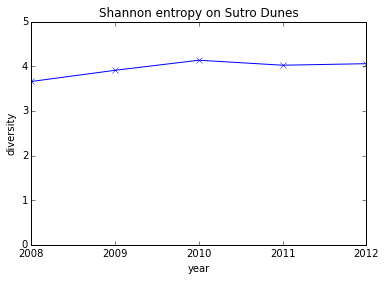

In [50]:
f = (dfpiv_sudu/dfpiv_sudu.sum())
shannon = - (f*np.log2(f)).sum()
shannon

plt.plot(shannon.index.tolist(), shannon, "x-")

x_formatter = plt.matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.gca().xaxis.set_major_formatter(x_formatter)
plt.xlim(xlims)
plt.xticks(range(xlims[0], xlims[-1]+1))
plt.ylim([0, np.ceil(max(shannon))])
plt.title("Shannon entropy on Sutro Dunes")
plt.xlabel("year")
plt.ylabel("diversity")
pass

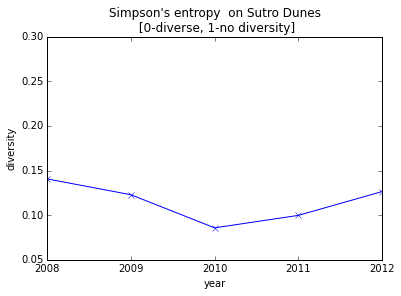

In [52]:
f = (dfpiv_sudu/dfpiv_sudu.sum())
simpsons =  (f**2).sum()
simpsons

plt.plot(shannon.index.tolist(), simpsons, "x-")

x_formatter = plt.matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.gca().xaxis.set_major_formatter(x_formatter)
plt.xlim(xlims)
plt.xticks(range(xlims[0], xlims[-1]+1))
#plt.ylim([0, np.ceil(max(simpsons))])
plt.title("Simpson's entropy  on Sutro Dunes\n [0-diverse, 1-no diversity]")
plt.xlabel("year")
plt.ylabel("diversity")
pass

In [16]:
dfpiv_all = pd.pivot_table(
    df_yr_sp.groupby(cols).agg("count").reset_index().\
    drop("site", axis = 1).groupby(["Species","year"]).\
    agg(sum).reset_index(), index = "Species", columns = "year").\
        fillna(0)

dfpiv_all.head()

count                         
year                   2008 2009 2010 2011 2012 2013
Species                                             
AVSP litter               0    0    2    0    0    0
Abronia latifolia         5    1    1    0    1    0
Achillea millefolium      0    0   12    9   25    0
Achillea millefolium     12   10    0    0    0    0
Albizia lophantha         0    1    1    0    1    0